In [ ]:
#Detecting Unbalanced Network Traffic Using XG-Boost , Random Forest And Ensemble of Both..

In [11]:
#XG-BOOST
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load the dataset
df = pd.read_csv('network_traffic.csv')
df.columns = df.columns.str.strip()
df.dropna(inplace=True)

# Convert text to IP Addresses 
def extract_ip_features(ip_str):
    try:
        parts = ip_str.split('-')
        if len(parts) == 3:
            src_ip, dest_ip, port = parts
            src_octets = [int(x) for x in src_ip.split('.')]
            dest_octets = [int(x) for x in dest_ip.split('.')]
            return src_octets + dest_octets + [int(port)]
        return [0] * 9
    except:
        return [0] * 9

if 'Src_Dest_Port' in df.columns:
    ip_features = df['Src_Dest_Port'].apply(extract_ip_features)
    ip_features_df = pd.DataFrame(ip_features.tolist(), columns=[f'IP_{i+1}' for i in range(9)])
    df = pd.concat([df, ip_features_df], axis=1).drop(columns=['Src_Dest_Port'])

# Encode categorical variables
label_encoder = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_encoder.fit_transform(df[col])

# Identify target variable
target_column = 'Label'
if target_column not in df.columns:
    raise KeyError("Label column not found. Available columns: " + str(df.columns))

# Remove the blank
class_counts = df[target_column].value_counts()
df = df[df[target_column].isin(class_counts[class_counts > 1].index)]

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Handle infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.max().max(), inplace=True)

# Convert to float32
X = X.astype(np.float32)

# Feature Selection - Variance Threshold
selector = VarianceThreshold(threshold=0.01)
X = pd.DataFrame(selector.fit_transform(X))

# Scale using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

# Select Best Features using Chi-Square
k_best = SelectKBest(score_func=chi2, k=min(50, X_scaled.shape[1]))
X_selected = pd.DataFrame(k_best.fit_transform(X_scaled, y))

# Apply SMOTE with dynamic k_neighbors
def apply_smote(X, y):
    counter = Counter(y)
    print("Class Distribution Before SMOTE:", counter)
    min_class_count = min(counter.values())
    k_neighbors = min(5, max(1, min_class_count - 1))
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("Class Distribution After SMOTE:", Counter(y_resampled))
    return X_resampled, y_resampled

X_resampled, y_resampled = apply_smote(X_selected, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Ensure class labels are sequential starting from 0
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert to DMatrix for Efficient XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train_encoded)
dtest = xgb.DMatrix(X_test, label=y_test_encoded)

# XGBoost Model with Optimized Parameters
params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y_train_encoded)),
    'eval_metric': 'mlogloss',
    'max_depth': 5,
    'learning_rate': 0.1,
    'tree_method': 'hist',
    'verbosity': 1
}

model = xgb.train(params, dtrain, num_boost_round=100)

# Predict and Decode Back to Original Labels
y_pred_encoded = model.predict(dtest)
y_pred = label_encoder.inverse_transform(y_pred_encoded.astype(int))

# Evaluation
print(f" XG-Boost Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Class Distribution Before SMOTE: Counter({0: 1487, 4: 146, 2: 89, 8: 87, 3: 9, 7: 6, 9: 5, 5: 4, 6: 2})
Class Distribution After SMOTE: Counter({0: 1487, 4: 1487, 6: 1487, 8: 1487, 2: 1487, 5: 1487, 9: 1487, 7: 1487, 3: 1487})
 XG-Boost Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           2       1.00      1.00      1.00       297
           3       1.00      1.00      1.00       298
           4       1.00      1.00      1.00       298
           5       1.00      1.00      1.00       298
           6       1.00      1.00      1.00       297
           7       1.00      1.00      1.00       298
           8       1.00      1.00      1.00       297
           9       1.00      1.00      1.00       297

    accuracy                           1.00      2677
   macro avg       1.00      1.00      1.00      2677
weighted avg       1.00      1.00      1.00      2677


Confusion Matri

In [5]:
#Random Forest Algorithm

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset
df = pd.read_csv("netwok_traffic.csv")  # Ensure the CSV file is in the same directory

# Trim spaces from column names to avoid key errors
df.columns = df.columns.str.strip()

# Drop missing values
df.dropna(inplace=True)

# Identify the target column
target_column = "Label" if "Label" in df.columns else " Label"

# Convert categorical columns to numeric using Label Encoding
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != target_column:  
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  

# Split features and target variable
X = df.drop(columns=[target_column])
y = df[target_column]

# Encode the target variable
y = LabelEncoder().fit_transform(y)

# Print class distribution before balancing
print("Class Distribution Before SMOTE:", Counter(y))

# Split dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to NumPy array for faster processing
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Handle infinite values & NaN
X_train = np.where(np.isinf(X_train), np.nan, X_train)
X_test = np.where(np.isinf(X_test), np.nan, X_test)

# Replace NaN with max finite value
finite_max = np.nanmax(X_train[np.isfinite(X_train)])  # Get max finite value
X_train = np.nan_to_num(X_train, nan=finite_max)
X_test = np.nan_to_num(X_test, nan=finite_max)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to only small classes (avoiding memory overload)
min_class_size = 100000
class_counts = Counter(y_train)
smote_dict = {cls: min_class_size for cls, count in class_counts.items() if count < min_class_size}
smote = SMOTE(sampling_strategy=smote_dict, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class Distribution After SMOTE:", Counter(y_train_resampled))

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Evaluate model performance
print("Random Forest Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Class Distribution Before SMOTE: Counter({0: 2272688, 4: 230124, 10: 158930, 2: 128027, 3: 10293, 7: 7938, 11: 5897, 6: 5796, 5: 5499, 1: 1966, 12: 1507, 14: 652, 9: 36, 13: 21, 8: 11})
Class Distribution After SMOTE: Counter({0: 1818150, 4: 184099, 10: 127144, 2: 102421, 7: 100000, 5: 100000, 3: 100000, 11: 100000, 12: 100000, 6: 100000, 1: 100000, 14: 100000, 9: 100000, 13: 100000, 8: 100000})
Random Forest Accuracy Score: 0.9999681909672951

Confusion Matrix:
 [[454534      0      0      0      0      0      0      0      0      0
       2      1      1      0      0]
 [     1    392      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0  25606      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0   2057      1      1      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0  46025      0      0      0      0      0
       0      0     

SMOTE cannot be applied as there are classes with <= 1 sample.
Ensemble Model Accuracy: 0.7973

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        55
           1       1.00      1.00      1.00         9
           2       0.00      1.00      0.00         0
           3       0.00      0.00      1.00         7
           6       1.00      0.00      0.00         3

    accuracy                           0.80        74
   macro avg       0.57      0.58      0.58        74
weighted avg       0.80      0.80      0.87        74


Confusion Matrix:
[[50  0  2  3  0]
 [ 0  9  0  0  0]
 [ 0  0  0  0  0]
 [ 5  0  2  0  0]
 [ 3  0  0  0  0]]


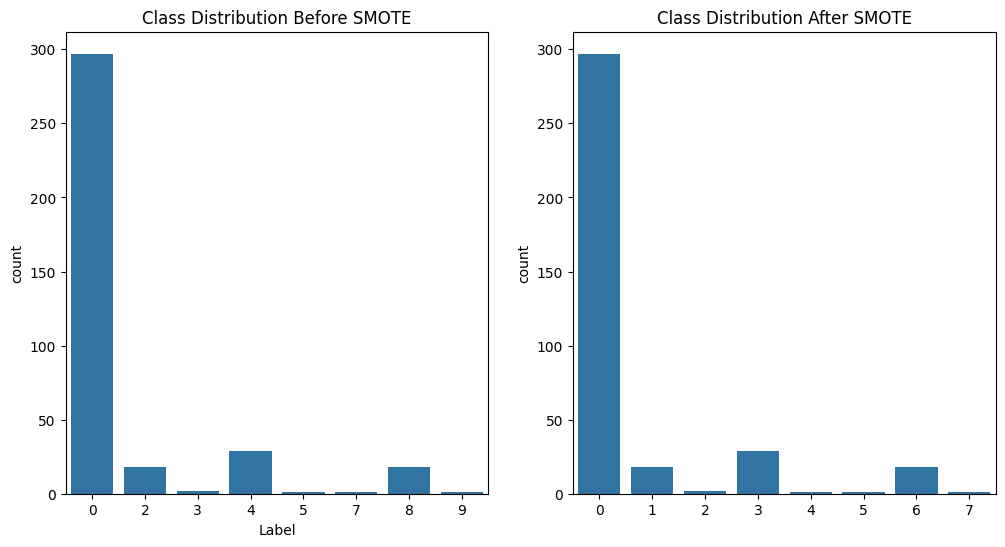

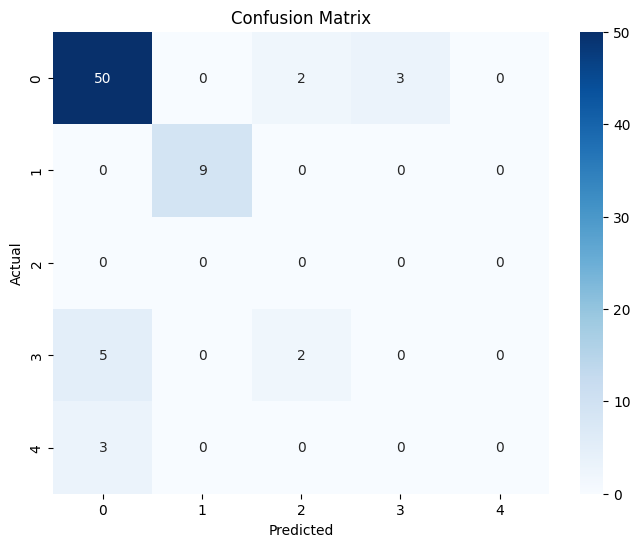

In [7]:
#Ensemble Model(Combination of XG-BOOST And Random Forest)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.feature_selection import VarianceThreshold
from collections import Counter

# Load dataset
df = pd.read_csv('network_traffic.csv')
df.columns = df.columns.str.strip()
df.dropna(inplace=True)

if 'Label' not in df.columns:
    raise KeyError("Label column not found. Available columns are: " + str(df.columns))

# Encode categorical data
label_encoder = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_encoder.fit_transform(df[col])
df['Label'] = label_encoder.fit_transform(df['Label'])

# Handle invalid values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Remove classes with fewer than 2 samples
class_counts = df['Label'].value_counts()
df = df[df['Label'].isin(class_counts[class_counts > 1].index)]

# Reduce data using stratified sampling
_, df_sampled = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)

# Remove low variance features
selector = VarianceThreshold(threshold=0.01)
X = pd.DataFrame(selector.fit_transform(df_sampled.drop(columns='Label')))
y = df_sampled['Label']

# Scale data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

# Handle imbalance using SMOTE
def apply_smote(X, y):
    counter = Counter(y)
    min_class_count = min(counter.values())

    if min_class_count <= 1:
        print("SMOTE cannot be applied as there are classes with <= 1 sample.")
        return X, y
    
    k_neighbors = min(5, max(1, min_class_count - 1))
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=k_neighbors)
    return smote.fit_resample(X, y)

X_resampled, y_resampled = apply_smote(X, y)

# Re-encode classes to ensure consistency
y_resampled = LabelEncoder().fit_transform(y_resampled)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train XGBoost and Random Forest models
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42)
xgb.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Stacking ensemble
xgb_preds_train = xgb.predict_proba(X_train)[:, 1]
rf_preds_train = rf.predict_proba(X_train)[:, 1]
stacked_features_train = np.column_stack((xgb_preds_train, rf_preds_train))

meta_model = LogisticRegression(class_weight='balanced', random_state=42)
meta_model.fit(stacked_features_train, y_train)

# Test
xgb_test_preds = xgb.predict_proba(X_test)[:, 1]
rf_test_preds = rf.predict_proba(X_test)[:, 1]
stacked_test_features = np.column_stack((xgb_test_preds, rf_test_preds))
final_preds = meta_model.predict(stacked_test_features)

# Evaluation
print(f'Ensemble Model Accuracy: {accuracy_score(y_test, final_preds):.4f}')
print("\nClassification Report:")
print(classification_report(y_test, final_preds, zero_division=1))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, final_preds))

# Visualization Functions
def plot_class_distribution(y_before, y_after):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_before)
    plt.title('Class Distribution Before SMOTE')
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_after)
    plt.title('Class Distribution After SMOTE')
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_multiclass_roc_curve(y_test, model, X_test):
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_prob = model.predict_proba(X_test)

    plt.figure(figsize=(10, 8))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Generate Visualizations
plot_class_distribution(y, y_resampled)
plot_confusion_matrix(y_test, final_preds)
